In [139]:
import os
from datetime import datetime
import dateutil.parser
import matplotlib.pyplot as plt

In [210]:
class Results():
    """
    Mori Results Parser
    """
    def __init__(self,root):
        self.root = root
        
        self.nsamples = int(self.root.split("_")[-1])
        
        try:
            self.runtimes = self.parse_log()
            self.total_runtime = get_total_runtime()
        except:
            print("run {} returned error when reading runtimes...".format(self.root))
            self.runtimes = None
            self.total_runtime = None
            
        try:
            self.accuracy, self.earliness, self.completeness= self.parse_simpleresults()
        except:
            print("run {} returned error when reading results...".format(self.root))
            self.accuracy, self.earliness, self.completeness = None, None, None
            pass
        
    def parse_log(self):

        with open(os.path.join(self.root,"run.log"),'r') as f:
            runlog = f.readlines()

        results=dict()
        for line, key in zip(runlog,["TrainProbabilities", "TestProbabilities", "Optimization", "Prediction"]):
            datestr = line[:31]
            date = dateutil.parser.parse(datestr)
            results[key]=date
        
        return results
    
    def parse_simpleresults(self):
        with open(os.path.join(self.root,"FinalResults/Others/NoReg/simpleresults-4-3-1-0.8-1.txt"),'r') as f:
            results = f.readlines()

        accuracy = float(results[1].replace("\n","").split(" ")[-1]) / 100
        earliness = float(results[2].replace("\n","").split(" ")[-1]) / 100
        completeness = float(results[3].replace("\n","").split(" ")[-1]) / 100
        
        return accuracy, earliness, completeness
    
    def get_total_runtime(self):
        return (self.runtimes["Prediction"] - self.runtimes["TrainProbabilities"]).total_seconds()
    
    def __str__(self):
        print("################################################################")
        print("Run "+self.root)
        print()
        if self.runtimes is not None:
            print("Runtime: {} s".format(self.get_total_runtime()))
        if self.accuracy is not None:
            print()
            print()
            print("Accuracy {}".format(self.accuracy))
            print("Earliness {}".format(self.earliness))
            print("Completeness {}".format(self.completeness))
        return ""
    
    def __dict__(self):
        return dict(
            nsamples=self.nsamples,
            runtime=self.total_runtime,
            accuracy=self.accuracy,
            earliness=self.earliness)
    
class ecResults():
    """
    Early Classification Model Parser
    """
    def __init__(self, root):
        
        self.root = root
        self.nsamples = int(self.root.split("/")[-1].replace("nsamples",""))
        try:
            self.accuracy, self.earliness = self.parse_accuracyearliness()
        except:
            print("run {} returned error when reading results...".format(self.root))
            self.accuracy, self.earliness, self.completeness = None, None, None
            pass
        
        try:
            self.runtime = self.get_total_runtime()
        except:
            print("run {} returned error when reading runtimes...".format(self.root))
            self.runtimes = None
            pass
    
    def parse_accuracyearliness(self):
        data = pd.read_csv(os.path.join(self.root,"BavarianCrops/data.csv"))
        accuracy = data.loc[data["mode"]=="test"].accuracy
        earliness = data.loc[data["mode"]=="test"].earliness
        return accuracy.values[0], earliness.values[0]
    
    def get_total_runtime(self):
        with open(self.root+".log","r") as f:
            lines = f.readlines()

        start = dateutil.parser.parse(lines[1].split(" ")[0])
        end = dateutil.parser.parse(lines[2].split(" ")[0])
        return (end-start).total_seconds()
    
    def __str__(self):
        print("################################################################")
        print("Run "+self.root)
        print()
        if self.runtimes is not None:
            print("Runtime: {} s".format(self.get_total_runtime()))
        if self.accuracy is not None:
            print()
            print()
            print("Accuracy {}".format(self.accuracy))
            print("Earliness {}".format(self.earliness))
            print("Completeness {}".format(self.completeness))
        return ""
    
    def __dict__(self):
        return dict(
            nsamples=self.nsamples,
            runtime=self.runtime,
            accuracy=self.accuracy,
            earliness=self.earliness)

In [198]:
runs = ["Results_50","Results_100","Results_250","Results_500","Results_750"]

In [199]:
for run in runs:
    print(Results(run))

################################################################
Run Results_50

Runtime: 1081.0 s


Accuracy 0.6875
Earliness 0.05
Completeness 1.0

################################################################
Run Results_100

Runtime: 1705.0 s


Accuracy 0.478260869565217
Earliness 0.0608695652173913
Completeness 1.0

################################################################
Run Results_250

Runtime: 4648.0 s


Accuracy 0.5483870967741941
Earliness 0.0556451612903226
Completeness 1.0

################################################################
Run Results_500

Runtime: 10520.0 s


Accuracy 0.592592592592593
Earliness 0.0511111111111111
Completeness 1.0

################################################################
Run Results_750

Runtime: 18348.0 s


Accuracy 0.570707070707071
Earliness 0.05
Completeness 1.0



In [200]:
stats = list()
for run in runs:
    result = Results(run)
    stats.append(result.__dict__())

In [211]:
runs = ["nsamples50","nsamples100","nsamples250","nsamples500",
        "nsamples750","nsamples1000","nsamples2500","nsamples5000","nsamples7500"]
ecstat = list()
for run in runs:
    result = ecResults(os.path.join("/data/ec_runtimes/",run))
    ecstat.append(result.__dict__())

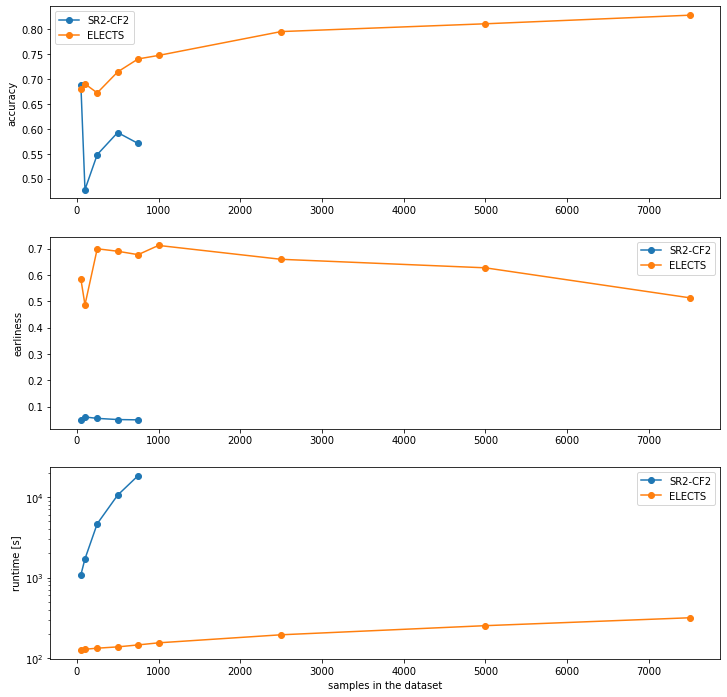

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(stats)
ecdf = pd.DataFrame(ecstat)

fig, ax = plt.subplots(3,1, figsize=(12,12))

ax[0].plot(df["nsamples"],df["accuracy"],'-o')
ax[0].plot(ecdf["nsamples"],ecdf["accuracy"],'-o')
ax[0].legend(["SR2-CF2","ELECTS"])
ax[0].set_ylabel("accuracy")


ax[1].plot(df["nsamples"],df["earliness"],'-o')
ax[1].plot(ecdf["nsamples"],ecdf["earliness"],'-o')
ax[1].legend(["SR2-CF2","ELECTS"])
ax[1].set_ylabel("earliness")

ax[2].plot(df["nsamples"],df["runtime"],'-o')
ax[2].plot(ecdf["nsamples"],ecdf["runtime"],'-o')
ax[2].legend(["SR2-CF2","ELECTS"])
ax[2].set_ylabel("runtime [s]")
ax[2].set_xlabel("samples in the dataset")
ax[2].set_yscale("log")